In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader import PuljaDataLoader
from models._dkt import UserModel
from models.utils import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 100

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c1, dataset.num_c2, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
tb_unit1 = pd.read_csv(
    os.path.join("tables", "tb_unit1.csv")
)
tb_unit2 = pd.read_csv(
    os.path.join("tables", "tb_unit2.csv")
)

c22c1 = {}
for _, row in tb_unit2.iterrows():
    c2 = row["name"]
    c1 = tb_unit1[tb_unit1["unit1Seq"] == row["unit1Seq"]]["name"].values[0]
    
    c22c1[c2] = c1

c22c1_indices = [dataset.c12idx[c22c1[c2]] for c2 in [dataset.c2_list[i] for i in range(dataset.num_c2)]]

In [4]:
model.load_state_dict(
    torch.load(
        os.path.join(
            os.path.join(
                ckpt_path, "_dkt"
            ),
            "model_max.ckpt"
        ),
        map_location=device
    )
)
model.eval()

UserModel(
  (X): Embedding(1267, 20)
  (gru): GRU(40, 20, batch_first=True)
  (out_layer): Linear(in_features=20, out_features=1267, bias=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
)

In [5]:
aucs_list = []
max_aucs = []
fin_aucs = []

dir_list = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]

for i in dir_list:
    with open(
        os.path.join(
            os.path.join(
                ckpt_path,
                os.path.join("_dkt", i)
            ),
            "aucs.pkl"
        ),
        "rb"
    ) as f:
        aucs = pickle.load(f)
    
    max_auc = np.max(aucs)
    fin_auc = aucs[-1]

    aucs_list.append(aucs)
    max_aucs.append(max_auc)
    fin_aucs.append(fin_auc)

In [6]:
print("max_aucs: {}".format(max_aucs))
print("max_auc_mean: {}, max_auc_std: {}".format(np.mean(max_aucs), np.std(max_aucs)))
print("max_auc_dir: {}".format(dir_list[np.argmax(max_aucs)]))

max_aucs: [0.7696048193178865, 0.7643372360794998, 0.7637118865385554, 0.7639634977475488, 0.7790276370558301, 0.7783375652706427, 0.7531969444058862, 0.7788972761253661, 0.7914604531168946, 0.7841911311180115]
max_auc_mean: 0.7726728446776121, max_auc_std: 0.011005537161934555
max_auc_dir: 09


In [7]:
print("max_fin_aucs: {}".format(fin_aucs))
print("max_fin_auc_mean: {}, max_auc_std: {}".format(np.mean(fin_aucs), np.std(fin_aucs)))
print("max_fin_auc_dir: {}".format(dir_list[np.argmax(fin_aucs)]))

max_fin_aucs: [0.7428123631412504, 0.7351612378742377, 0.7312029941208571, 0.7283144801041327, 0.7514670256637196, 0.7407233299625172, 0.7186284596828414, 0.7592853964849422, 0.7653674240548058, 0.7622962609973608]
max_fin_auc_mean: 0.7435258972086665, max_auc_std: 0.014907235747504466
max_fin_auc_dir: 09


In [8]:
test_dataset[100]

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163,
        163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163,
        163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163,
        163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163,
        163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163,
        163, 163, 163, 163, 163, 163, 164, 164, 164, 164, 164, 164, 164,
        164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164, 164,
        164, 164, 164, 164, 164, 164, 164, 164, 164, 164]),
 array([0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2,
        3,

In [13]:
# 0, 1, 3, 5, 19, 20
c1_seq, c2_seq, d_seq, r_seq = test_dataset[1]

c1_seq, c1shft_seq = [c1_seq[:-1]], [c1_seq[1:]]

c2_seq, c2shft_seq = [c2_seq[:-1]], [c2_seq[1:]]

d_seq, dshft_seq = [d_seq[:-1]], [d_seq[1:]]

r_seq, rshft_seq = [r_seq[:-1]], [r_seq[1:]]

# r_seq = np.zeros_like(r_seq)
# r_seq = np.ones_like(r_seq)

# d_seq = np.ones_like(d_seq) * 6

# c_seq = np.array([[0] * 100])
# d_seq = np.array([[6] * 30 + [3] * 30 + [0] * 40])
# r_seq = np.ones_like(r_seq)

###########################################
alpha_seq, h_seq = model(
    LongTensor(c2_seq),
    LongTensor(d_seq),
    FloatTensor(r_seq),
)
alpha_seq = alpha_seq.squeeze()

C_seq = alpha_seq.mean(-1)
alpha_seq = C_seq.mean(-1)
###########################################

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()

# sigmoid_alpha_beta_seq = torch.sigmoid(alpha_seq + beta_seq).detach().cpu().numpy()[0]

# sigmoid_alpha_beta_gamma_seq = torch.sigmoid(alpha_seq + beta_seq - gamma_seq).detach().cpu().numpy()[0]

r_seq_ma = np.cumsum(r_seq[0]) / np.arange(1, r_seq[0].shape[0] + 1)

CQ_seq = torch.sigmoid(C_seq.squeeze() + alpha_seq.unsqueeze(-1)).detach().cpu().numpy()
C_seq = C_seq.squeeze().detach().cpu().numpy()

# alpha_seq = alpha_seq.detach().cpu().numpy()

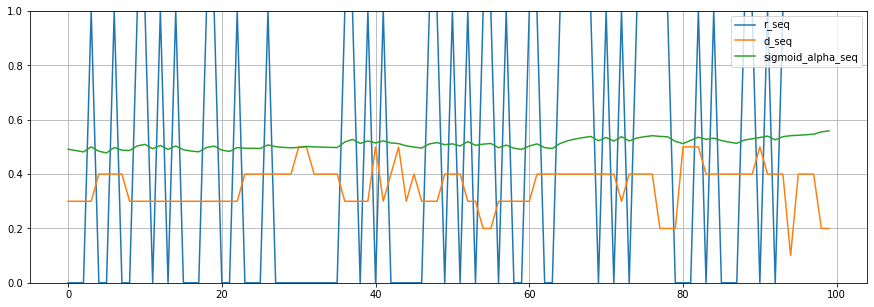

In [14]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
# plt.plot(sigmoid_alpha_beta_seq, label="sigmoid_alpha_beta_seq")
# plt.plot(sigmoid_alpha_beta_gamma_seq, label="sigmoid_alpha_beta_gamma_seq")
# plt.plot(r_seq_ma, label="r_seq_ma")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

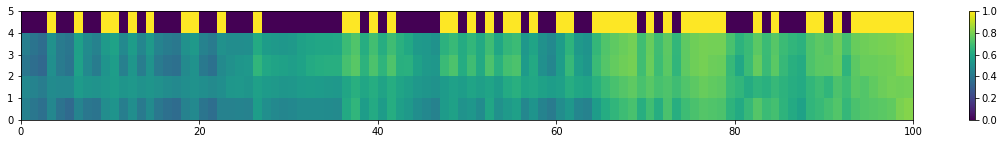

In [15]:
plt.figure(figsize=[20, len(np.unique(c2_seq)) // 2], facecolor="white")
temp = np.concatenate([CQ_seq[:, np.unique(c2_seq)].T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

# plt.figure(figsize=[15, 0.5], facecolor="white")
# plt.pcolormesh(r_seq)
# plt.show()

In [16]:
CQ_seq[0][np.unique(c2_seq)], CQ_seq[-1][np.unique(c2_seq)], np.unique(c2_seq), c2_seq, d_seq

(array([0.43566322, 0.4702554 , 0.3980063 , 0.42768636], dtype=float32),
 array([0.8149743 , 0.78869593, 0.8218174 , 0.8231432 ], dtype=float32),
 array([114, 115, 134, 168]),
 [array([168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168,
         168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 114, 114, 114,
         114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 115, 115, 115,
         115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115,
         115, 115, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168,
         168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168,
         168, 168, 168, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115,
         134, 134, 134, 134, 134, 134, 134, 134, 134])],
 [array([2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 4, 2, 3, 4,
         2, 3, 2, 2, 2, 3, 3, 3, 2, 2, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 